In [16]:
import geopandas
from matplotlib import colors
import matplotlib.pyplot as plt
from descartes import PolygonPatch
import geohash
import numpy as np
import cartopy.crs as ccrs
import pandas as pd

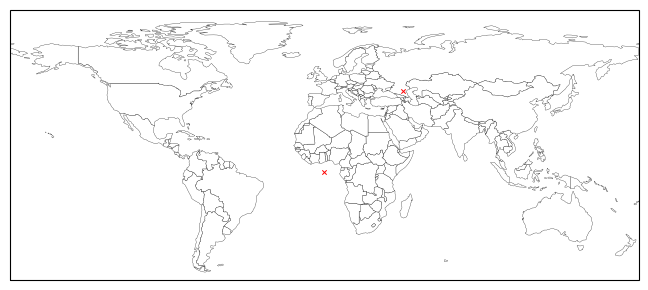

In [32]:
gsdata_satnog = pd.read_csv("data/gsdata/gsdata_satnog.csv")
gsdata_ksat   = pd.read_csv("data/gsdata/gsdata_ksat.csv")
gsdata_atlas  = pd.read_csv("data/gsdata/gsdata_atlas.csv")
gsdata_leaf   = pd.read_csv("data/gsdata/gsdata_leaf.csv")


continents = ["AF", "AS", "EU", "NA", "OC", "SA"]
cols = ["#c1d5e2", "#ce9c7f", "#7598b6", "#6a7465", "#914c09", "#663979", "#fbe17b"]

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")]

def plotCountryPatch( axes, country_name, fcolor ):
    # plot a country on the provided axes
    nami = world[world.name == country_name]
    namigm = nami.__geo_interface__['features']  # geopandas's geo_interface
    namig0 = {'type': namigm[0]['geometry']['type'], \
              'coordinates': namigm[0]['geometry']['coordinates']}
    axes.add_patch(PolygonPatch( namig0, fc=fcolor, ec="black", alpha=0.85, zorder=2, linewidth=0.0 ))


fig, ax = plt.subplots(figsize=(7, 3), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = colors.ListedColormap(cols[:-2])
world.plot(facecolor = "white", edgecolor="black", ax=ax, linewidth=0.2)

# Plotting GS points
def plot_gsdata(gsdata_df, ax, marker):
    latitude, longitude = gsdata_df["lat"], gsdata_df["long"]
    ax.scatter(latitude, longitude, sizes = [10], color="red", zorder = 10, marker=marker, linewidth = 0.7)

plot_gsdata(gsdata_ksat, ax, "x")
    
ax.set_extent([-180, 180, -60, 90], ccrs.PlateCarree())
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

plt.tight_layout()
plt.savefig("mlab_availabilitynprobes.pdf", pad_inches=0)
plt.show()